## Lec 8. 编码器-解码器结构

- Encoder-Decoder
    - VAE `变分自编码器` Variational Auto-Encoders
    - Seq2Seq `序列到序列`
    - Transformer
 

### 8.1 Variational Auto-Encoders
- 调整网络结构：
    - 使用卷积神经网络
    - 添加正则化层 (Dropout / BatchNorm)
    - 使用更深的网络结构
    - ......

- VAE的使用场景
    - 图像生成，文本生成，音频生成.....
    - 数据增强

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class VAE(nn.Module):
    """ 变分自编码器 """
    def __init__(self, input_size=784, hidden_size=256, latent_size=32):
        super().__init__()

        # Encoder 编码器
        self.encoder = nn.Sequential(nn.Linear(input_size, hidden_size), 
                                     nn.ReLU(), 
                                     
                                     nn.Linear(hidden_size, hidden_size//2), 
                                     nn.ReLU())

        # 计算 Latent Space的均值和对数方差
        self.fc_mu = nn.Linear(hidden_size//2, latent_size)
        self.fc_logvar = nn.Linear(hidden_size//2, latent_size)

        # Decoder 解码器
        self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size//2), 
                                     nn.ReLU(), 
                                     
                                     nn.Linear(hidden_size//2, hidden_size), 
                                     nn.ReLU(), 
                                     
                                     nn.Linear(hidden_size, input_size), 
                                     nn.Sigmoid()) # 将输出压缩到 [0, 1] 范围内

    def reparameterize(self, mu, logvar):
        """ 重参数化方法 """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """ 前向传播方法 """
        # 编码过程
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
    
        # 重参数化
        z = self.reparameterize(mu, logvar)

        # 解码过程
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [3]:
model = VAE()
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [4]:
# 1. 构建数据集
import torchvision
from torch.utils.data import DataLoader

dataset = torchvision.datasets.MNIST(root="mnist/", 
                                     train=True, 
                                     download=True, 
                                     transform=torchvision.transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    """ VAE损失函数, Loss = 重构损失 + KL散度 """
    # 重构损失 (交叉熵)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
# 2. 构建模型
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = VAE().to(device)
loss_func = vae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# 3. 模型训练
def train_model(model, loss_func, optimizer, dataloader):
    """ 模型训练函数 """
    model.train()
    total_loss = 0.
    for x, _ in dataloader:
        x = x.to(device)
        x_recon, mu, logvar = model(x.view(-1, 784))
        loss = loss_func(x_recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Loss: {total_loss/len(dataloader): 0.4f}")
    return total_loss/len(dataloader)

Loss:  54730.5959
Loss:  42676.5434
Loss:  36488.6971
Loss:  33352.5640
Loss:  31624.0120
Loss:  30589.1935
Loss:  29844.1860
Loss:  29266.5805
Loss:  28839.9716
Loss:  28482.5489
Loss:  28186.2108
Loss:  27946.3325
Loss:  27724.7324
Loss:  27565.6009
Loss:  27422.2501
Loss:  27297.7688
Loss:  27187.8959
Loss:  27084.4150
Loss:  26984.0842
Loss:  26894.4766


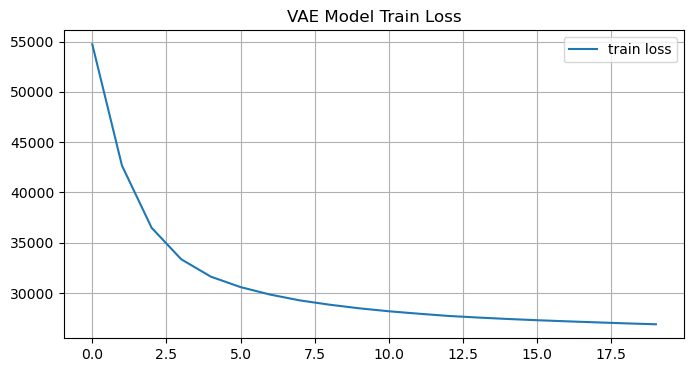

In [8]:
n_epoch = 20
train_loss = []

for i in range(n_epoch):
    loss = train_model(model, loss_func, optimizer, dataloader)
    train_loss.append(loss)

import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

plt.figure(figsize=(8, 4))
plt.plot(train_loss, label="train loss")
plt.title("VAE Model Train Loss")
plt.legend()

plt.grid()
plt.show()

In [9]:
# 使用 VAE 进行数据增强
with torch.no_grad():
    # 从标准正态分布中采样 Latent 潜层特征
    z = torch.randn(32, 32).to(device)

    # 通过VAE解码器将采样得到的 潜层特征生成样本 (28x28的图像数据)
    generated_samples = model.decoder(z).view(-1, 1, 28, 28).to("cpu")

generated_samples.shape

torch.Size([32, 1, 28, 28])

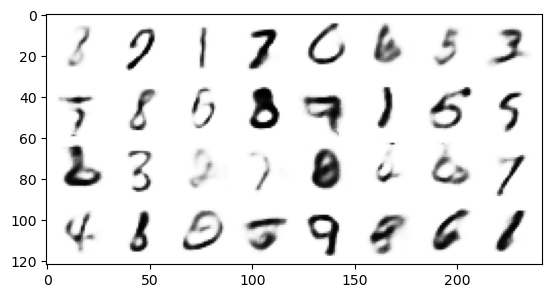

In [10]:
plt.imshow(torchvision.utils.make_grid(generated_samples)[0], cmap="Greys")

### 8.2 Seq2Seq
- 生成式模型
- 用于处理序列形式的数据

- 强制教学

In [11]:
class Seq2SeqEncoder(nn.Module):
    """ Seq2Seq 编码器 """
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # 特征提取层
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, x, hidden=None):
        """ 前向传播方法 """
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # embedded: [batch_size, seq_len, embedding_size]
        output, hidden = self.rnn(embedded, hidden)
        # output: [batch_size, seq_len, hidden_size]
        # hidden, cell: [num_layers, batch_Size, hidden_size]
        return output, hidden

In [12]:
class Seq2SeqDecoder(nn.Module):
    """ Seq2Seq 解码器 """
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # 特征提取层
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        # 全连接层
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, last_hidden):
        """ 前向传播方法 """
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # embedded: [batch_size, seq_len, embedding_size]
        output, hidden = self.rnn(embedded, last_hidden)
        # output: [batch_size, seq_len, hidden_size]
        # hidden, cell: [num_layers, batch_Size, hidden_size]
        output = self.fc(output) # output: [batch_size, seq_len, vocab_size]
        return output, hidden

In [13]:
x = torch.zeros(16, 20).long()

encoder = Seq2SeqEncoder(13000, 64, 32, 2, 0.1)
output, hidden = encoder(x)

output.shape, hidden.shape

(torch.Size([16, 20, 32]), torch.Size([2, 16, 32]))

In [14]:
x = torch.zeros(16, 20).long()

decoder = Seq2SeqDecoder(12500, 64, 32, 2, 0.1)
output, hidden = decoder(x, hidden)

output.shape

torch.Size([16, 20, 12500])

In [15]:
# 1. 构建数据集
class Vocab:
    """ 用于存储单词词元映射关系的词典 """
    def __init__(self):
        self.word2idx = {"<BOS>": 0, "<EOS>": 1, "<PAD>": 2}
        self.idx2word = ["<BOS>", "<EOS>", "<PAD>"]

    def add(self, word):
        """ 向词典中添加新的单词 """
        if word not in self.idx2word:
            self.word2idx[word] = len(self.idx2word)
            self.idx2word.append(word)

    def get_dummies(self, word):
        if word in self.idx2word:
            one_hot = torch.zeros(len(self.idx2word))
            one_hot[self.word2idx.get(word)] = 1
            return one_hot

    def __len__(self):
        return len(self.idx2word)

def text_preprocess(sentence: str) -> str:
    """ 文本预处理函数 """
    sentence = sentence.lower().strip()
    import re
    sentence = re.sub(r"([.!?])", r"\1", sentence)
    sentence = re.sub(r"[^a-zA-Z!?]", r" ", sentence)
    return sentence.strip()

In [19]:
vocab_eng = Vocab()
vocab_fra = Vocab()

eng_corpus = []
fra_corpus = []

with open("C:/Users/LENOVO/eng-fra.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        eng, fra = line.split("\t")
        eng, fra = text_preprocess(eng), text_preprocess(fra)
    
        for word in eng.split(" "):
            vocab_eng.add(word)
        for word in fra.split(" "):
            vocab_fra.add(word)
        eng_corpus.append(eng.split(" "))
        fra_corpus.append(fra.split(" "))

len(vocab_eng.word2idx), len(vocab_fra.word2idx)

(15565, 19002)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class NMTDataset(Dataset):
    """ 机器翻译数据集 """
    def __init__(self, vocab_eng, vocab_fra, eng_corpus, fra_corpus, seq_len=20):
        self.eng_data = []
        self.fra_data = []

        for line in eng_corpus:
            line = ["<BOS>"] + line[:seq_len-2] + ["<EOS>"]
            if len(line) < seq_len:
                line += ["<PAD>"] * (seq_len-len(line))
            self.eng_data.append([vocab_eng.word2idx.get(x) for x in line])

        for line in fra_corpus:
            line = ["<BOS>"] + line[:seq_len-2] + ["<EOS>"]
            if len(line) < seq_len:
                line += ["<PAD>"] * (seq_len-len(line))
            self.fra_data.append([vocab_fra.word2idx.get(x) for x in line])

    def __len__(self):
        return len(self.eng_data)

    def __getitem__(self, idx):
        eng_tensor = torch.tensor(self.eng_data[idx]).long()
        fra_tensor = torch.tensor(self.fra_data[idx]).long()
        return eng_tensor, fra_tensor

dataset = NMTDataset(vocab_eng, vocab_fra, eng_corpus, fra_corpus, seq_len=20)

In [ ]:
src, trg = dataset[:16]
src.shape, trg.shape

(torch.Size([16, 20]), torch.Size([16, 20]))

In [ ]:
import random

# 2. 模型构建
class Seq2Seq(nn.Module):
    """ 序列到序列模型 """
    def __init__(self, embedding_size, hidden_size, num_layers, lang1_vocab_size, lang2_vocab_size):
        super().__init__()
        # 编码器部分
        self.encoder = Seq2SeqEncoder(lang1_vocab_size, embedding_size, hidden_size, num_layers)
        # 解码器部分
        self.decoder = Seq2SeqDecoder(lang2_vocab_size, embedding_size, hidden_size, num_layers)

        self.trg_vocab_size = lang2_vocab_size

    def forward(self, src, trg, teacher_forcing_rate=0.5):
        """ 前向传播方法 """
        # src: [batch_size, seq_len]
        # trg: [batch_size, seq_len]
        batch_size = src.shape[0]
        seq_len = src.shape[1]

        outputs = torch.zeros(batch_size, seq_len, self.trg_vocab_size)

        encoder_output, hidden_state = self.encoder(src)
        # encoder_output: [batch_size, seq_len, hidden_size]
        # hidden_state: [num_layers, batch_size, hidden_size]

        decoder_input_token = torch.zeros(batch_size).long()  # decoder_input_token: [batch_size, 1] -> <BOS>: 0
        
        for step in range(1, seq_len):
            decoder_output, hidden_state = self.decoder(decoder_input_token.view(-1, 1), hidden_state) # decoder_output: [batch_size, lang2_vocab_size]
            outputs[:, step, :] = decoder_output.squeeze(1)  # decoder_output.squeeze(1): [batch_size, 1, lang2_vocab_size]

            # 强制教学  Teacher-Forcing
            is_teacher = random.random() < teacher_forcing_rate
            top1 = decoder_output.max(-1)[1].view(-1)
            decoder_input_token = trg[: , step] if is_teacher else top1
        return outputs

In [ ]:
model = Seq2Seq(512, 26, 2, len(vocab_eng), len(vocab_fra))
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
outputs = model(src, trg, 0.5)
outputs.shape

torch.Size([16, 20, 19002])

In [ ]:
" ".join([vocab_fra.idx2word[x] for x in torch.argmax(outputs, -1).cpu().numpy()[2]])

'<BOS> songiez songiez occidentale voudras chappa ri pancarte figurer figurer parole parole hirondelle cultive cultive parole posons posons conomistes conomistes'

In [ ]:
# 3. 模型训练
def train_model():
    """  """
    pass